# Seattle Weather Classification Project

## Overview
This project aims to predict Seattle weather conditions based on historical weather features using multiple machine learning models. We'll implement a thorough data science workflow including exploratory data analysis, feature engineering, model training with hyperparameter optimization, and detailed evaluation.

### Models Implemented:
- Logistic Regression
- Decision Tree
- K-Nearest Neighbors (KNN)
- Random Forest
- XGBoost

### Project Structure:
1. Data Loading & Initial Exploration
2. Enhanced Data Preprocessing & Feature Engineering
3. Exploratory Data Analysis with Visualizations
4. Model Implementation with Hyperparameter Tuning
5. Model Evaluation & Comparison
6. Conclusion & Recommendations

## 1. Library Imports

We begin by importing all necessary libraries for our analysis:
- Data manipulation: pandas, numpy
- Visualization: matplotlib, seaborn
- Machine learning: scikit-learn, XGBoost
- Model evaluation: metrics, hyperparameter tuning tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score



## 2. Data Loading & Initial Exploration

Let's load the Seattle weather dataset and explore its basic structure. This step helps us understand the data before any processing.

In [2]:
# loading the dataset
data = pd.read_csv("seattle-weather.csv")

# checking basic info for further use
print("Dataset Shape:", data.shape)
print("\nFirst 5 Rows:")
display(data.head())

print("\nData Information:")
data.info()

print("\nDescriptive Statistics:")
display(data.describe())

print("\nTarget Variable Distribution:")
display(data['weather'].value_counts().to_frame())

Dataset Shape: (1461, 6)

First 5 Rows:


,date,precipitation,temp_max,temp_min,wind,weather
0,01-01-2012,0.0,12.8,5.0,4.7,drizzle
1,02-01-2012,10.9,10.6,2.8,4.5,rain
2,03-01-2012,0.8,11.7,7.2,2.3,rain
3,04-01-2012,20.3,12.2,5.6,4.7,rain
4,05-01-2012,1.3,8.9,2.8,6.1,rain



Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB

Descriptive Statistics:


,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000



Target Variable Distribution:


,count
weather,
rain,641
sun,640
fog,101
drizzle,53
snow,26


### 2.1 Check for Missing Values

Identifying and handling missing values is crucial for building good and accurate models.

In [3]:
# check for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
display(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

Missing Values:


'No missing values found'

No missing value so no need of imputation

## 3. Enhanced Data Preprocessing & Feature Engineering

We'll perform several preprocessing steps to enhance our dataset:
1. Convert date to datetime and extract temporal features
2. Create seasonal features
3. Engineer weather-related features
4. Encode categorical variables
5. Scale numerical features

In [4]:
# creating a copy of dataset
processed_data = data.copy()

# converting date into a specified format
processed_data['date'] = pd.to_datetime(processed_data['date'], dayfirst=True)

# making new columns for the dataset which will have the date
processed_data['year'] = processed_data['date'].dt.year
processed_data['month'] = processed_data['date'].dt.month
processed_data['day'] = processed_data['date'].dt.day
processed_data['day_of_week'] = processed_data['date'].dt.dayofweek
processed_data['day_of_year'] = processed_data['date'].dt.dayofyear

# defining a new column for season with month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

processed_data['season'] = processed_data['month'].apply(get_season)

# checking the dataset now
print("Processed dataframe with new features:")
display(processed_data.head())

Processed dataframe with new features:


,date,precipitation,temp_max,temp_min,wind,weather,year,month,day,day_of_week,day_of_year,season
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,2012,1,1,6,1,Winter
1,2012-01-02,10.9,10.6,2.8,4.5,rain,2012,1,2,0,2,Winter
2,2012-01-03,0.8,11.7,7.2,2.3,rain,2012,1,3,1,3,Winter
3,2012-01-04,20.3,12.2,5.6,4.7,rain,2012,1,4,2,4,Winter
4,2012-01-05,1.3,8.9,2.8,6.1,rain,2012,1,5,3,5,Winter


### 3.1 Advanced Feature Engineering

Let's create some weather-specific features that might help our models better understand the patterns:

In [5]:
# calculate temperature range
processed_data['temp_range'] = processed_data['temp_max'] - processed_data['temp_min']

# making percipitation categories
def categorize_precipitation(precip):
    if precip == 0:
        return 'None'
    elif precip < 2.5:
        return 'Light'
    elif precip < 7.6:
        return 'Moderate'
    else:
        return 'Heavy'

processed_data['precip_category'] = processed_data['precipitation'].apply(categorize_precipitation)



# experimenting with making a new column
processed_data['feels_like'] = processed_data['temp_max'] - (0.05 * processed_data['wind'])

# reviewing the new features
display(processed_data[['temp_max', 'temp_min', 'temp_range', 'precipitation', 
                      'precip_category', 'feels_like']].head(10))

,temp_max,temp_min,temp_range,precipitation,precip_category,feels_like
0,12.8,5.0,7.8,0.0,None,12.565
1,10.6,2.8,7.8,10.9,Heavy,10.375
2,11.7,7.2,4.5,0.8,Light,11.585
3,12.2,5.6,6.6,20.3,Heavy,11.965
4,8.9,2.8,6.1,1.3,Light,8.595
5,4.4,2.2,2.2,2.5,Moderate,4.290
6,7.2,2.8,4.4,0.0,None,7.085
7,10.0,2.8,7.2,0.0,None,9.900
8,9.4,5.0,4.4,4.3,Moderate,9.230
9,6.1,0.6,5.5,1.0,Light,5.930


### 3.2 Categorical Feature Encoding

We need to encode categorical features for our machine learning models. For the weather target variable, we'll use a label encoder to maintain the ordinal relationship between weather conditions. For other categorical features, we'll use one-hot encoding.

In [6]:
# store original weather labels 
weather_labels = processed_data['weather'].unique()
print(f"Original weather categories: {weather_labels}")

# encoding 
label_encoder = LabelEncoder()
processed_data['weather_encoded'] = label_encoder.fit_transform(processed_data['weather'])
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nWeather encoding mapping:")
print(mapping)

# One-Hot encoding
categorical_features = ['precip_category']
processed_data_encoded = pd.get_dummies(processed_data, columns=categorical_features, drop_first=False)

#Checking the dataset
print("\nDataframe after encoding (showing first few columns):")
display(processed_data_encoded.head())

Original weather categories: ['drizzle' 'rain' 'sun' 'snow' 'fog']

Weather encoding mapping:
{'drizzle': 0, 'fog': 1, 'rain': 2, 'snow': 3, 'sun': 4}

Dataframe after encoding (showing first few columns):


,date,precipitation,temp_max,temp_min,wind,weather,year,month,day,day_of_week,day_of_year,season,temp_range,feels_like,weather_encoded,precip_category_Heavy,precip_category_Light,precip_category_Moderate,precip_category_None
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,2012,1,1,6,1,Winter,7.8,12.565,0,False,False,False,True
1,2012-01-02,10.9,10.6,2.8,4.5,rain,2012,1,2,0,2,Winter,7.8,10.375,2,True,False,False,False
2,2012-01-03,0.8,11.7,7.2,2.3,rain,2012,1,3,1,3,Winter,4.5,11.585,2,False,True,False,False
3,2012-01-04,20.3,12.2,5.6,4.7,rain,2012,1,4,2,4,Winter,6.6,11.965,2,True,False,False,False
4,2012-01-05,1.3,8.9,2.8,6.1,rain,2012,1,5,3,5,Winter,6.1,8.595,2,False,True,False,False


### 3.3 Feature Selection and Data Preparation

Now we'll prepare our feature set, scale numerical features, and split the data into training and testing sets. We'll drop the original date column and original categorical columns that have been one-hot encoded.

In [7]:
# dropping the following columns
processed_data_encoded.drop(['date', 'weather'], axis=1, inplace=True)


# separate features and target
X = processed_data_encoded.drop('weather_encoded', axis=1)
y = processed_data_encoded['weather_encoded']

# scaling
numerical_features = ['precipitation', 'temp_max', 'temp_min', 'wind', 
                      'year', 'month', 'day', 'day_of_week', 'day_of_year', 
                      'temp_range', 'feels_like']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# creating an encoder for season (wasn't done before)
le = LabelEncoder()
X['season_encoded'] = le.fit_transform(X['season'])
X.drop(['season'], axis=1, inplace=True)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                   random_state=21, 
                                                   stratify=y)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


# feature names for later use
feature_names = X.columns.tolist()

Training set shape: (1241, 16), (1241,)
Testing set shape: (220, 16), (220,)


## 4. Exploratory Data Analysis (EDA)

Before modeling, let's perform a comprehensive exploratory data analysis to understand patterns and relationships in our data.

### 4.1 Target Variable Distribution

Understanding the distribution of weather conditions helps us identify any class imbalances that might affect our modeling strategy.

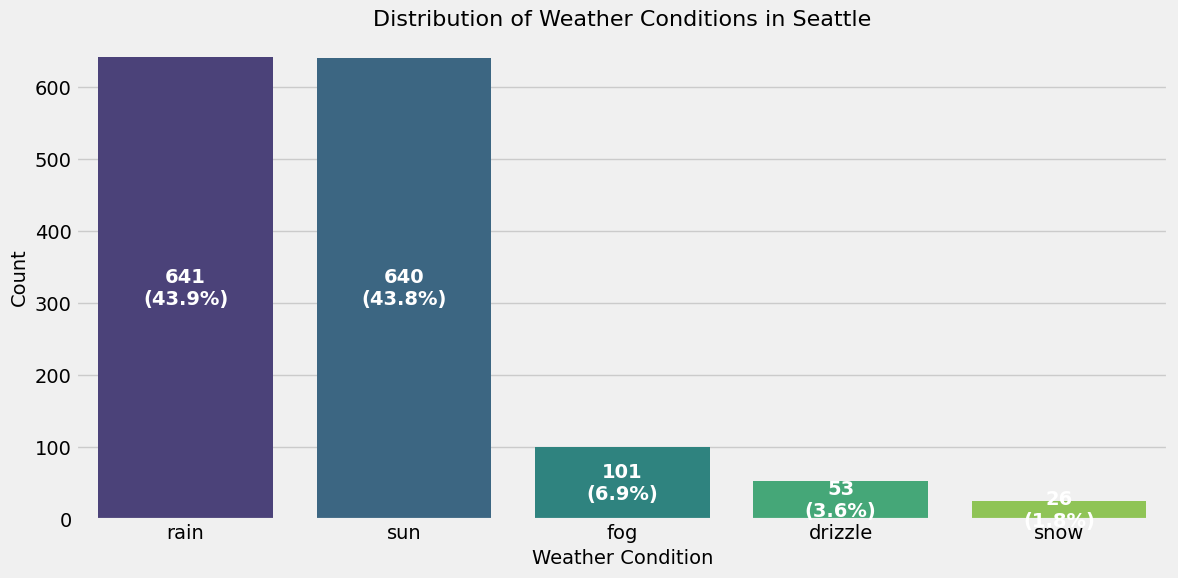

In [24]:
plt.figure(figsize=(12, 6))
target_dist = data['weather'].value_counts()

# making a colour palette
colors = sns.color_palette('viridis', len(target_dist))

# plotting
ax = sns.barplot(x=target_dist.index, y=target_dist.values, hue=target_dist.index, palette=colors, legend=False)
plt.title('Distribution of Weather Conditions in Seattle', fontsize=16)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('Count', fontsize=14)

# add count and percentage labels on each bar
total = len(data)
for i, count in enumerate(target_dist.values):
    percentage = 100 * count / total
    ax.text(i, count//2, f'{count}\n({percentage:.1f}%)', 
            ha='center', va='center', color='white', fontweight='bold')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

As it can be observed that the data is primarily dominated by rain and sun as weather conditions. Other weather condition like fog, drizzle and snow are present in very less amount.

### 4.2 Seasonal Weather Patterns

Let's visualize how weather conditions change across different months and seasons. This can help us understand the temporal patterns in Seattle's weather.

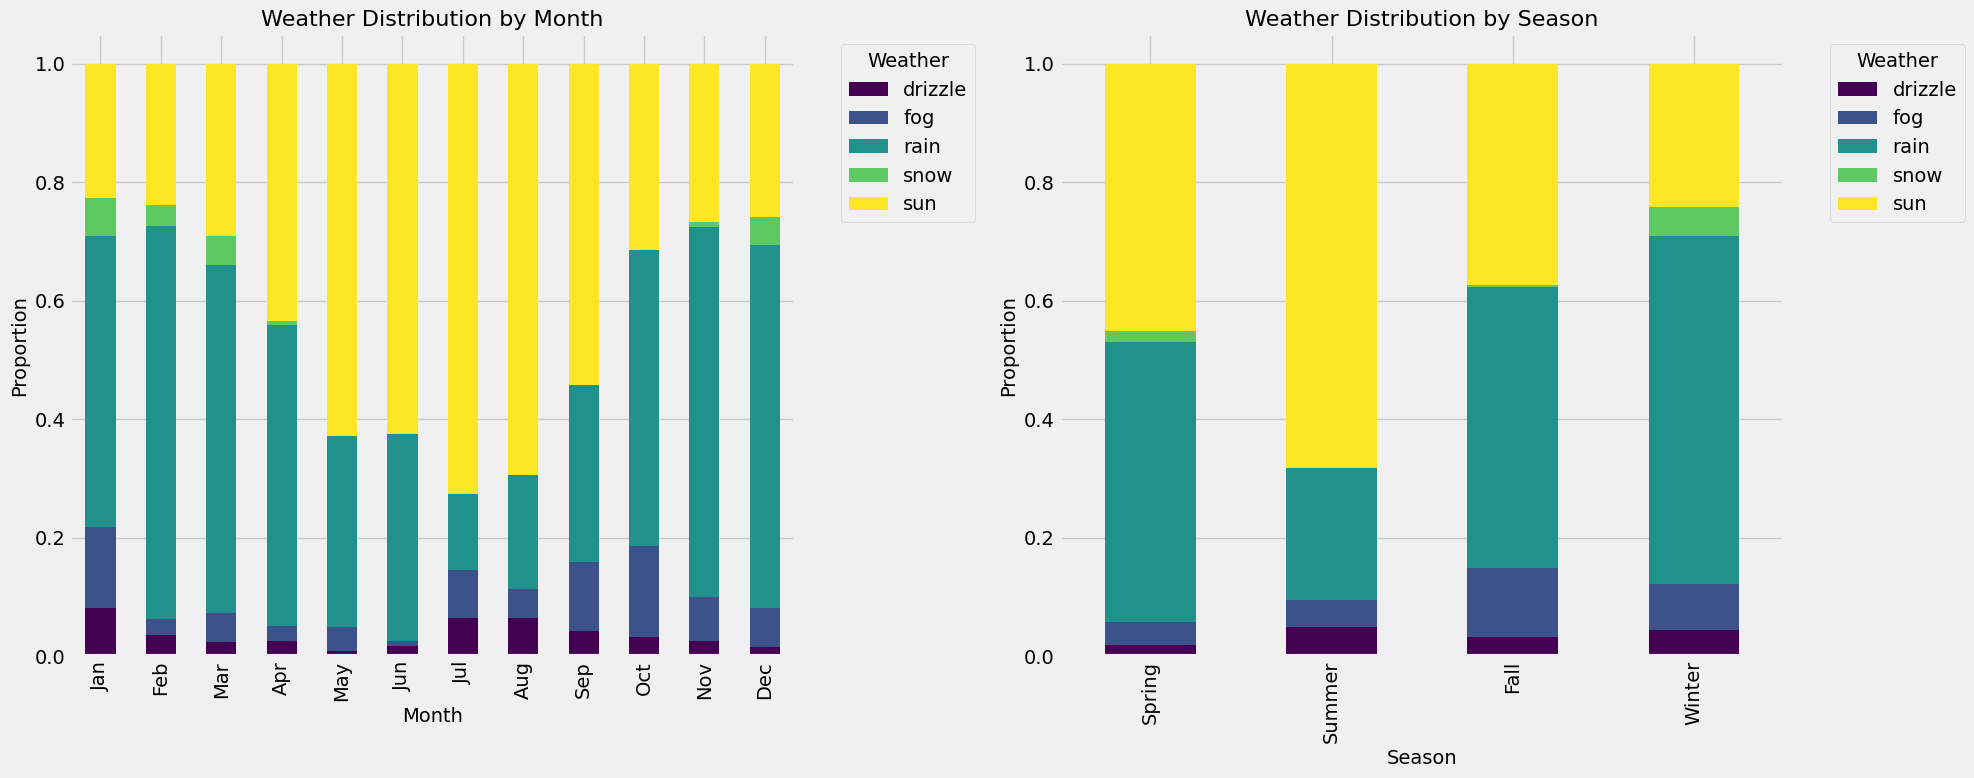

In [9]:
# making a figure with 2 graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# graph 1: weather distribution by month
month_weather = pd.crosstab(processed_data['month'], processed_data['weather'])
month_weather_norm = month_weather.div(month_weather.sum(axis=1), axis=0)

month_weather_norm.plot(kind='bar', stacked=True, ax=ax1, colormap='viridis')
ax1.set_title('Weather Distribution by Month', fontsize=16)
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Proportion', fontsize=14)
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.legend(title='Weather', bbox_to_anchor=(1.05, 1), loc='upper left')

# graph 2: weather distribution by season
season_weather = pd.crosstab(processed_data['season'], processed_data['weather'])
season_weather_norm = season_weather.div(season_weather.sum(axis=1), axis=0)

# define season order
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_weather_norm = season_weather_norm.loc[season_order]

season_weather_norm.plot(kind='bar', stacked=True, ax=ax2, colormap='viridis')
ax2.set_title('Weather Distribution by Season', fontsize=16)
ax2.set_xlabel('Season', fontsize=14)
ax2.set_ylabel('Proportion', fontsize=14)
ax2.legend(title='Weather', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

We can observe that the months of July and August have most rains (makes sense). It can be further observed that summer has the most sun (makes sense).

### 4.3 Correlation Analysis

Let's examine the correlation between numerical features to understand the relationships between weather variables.

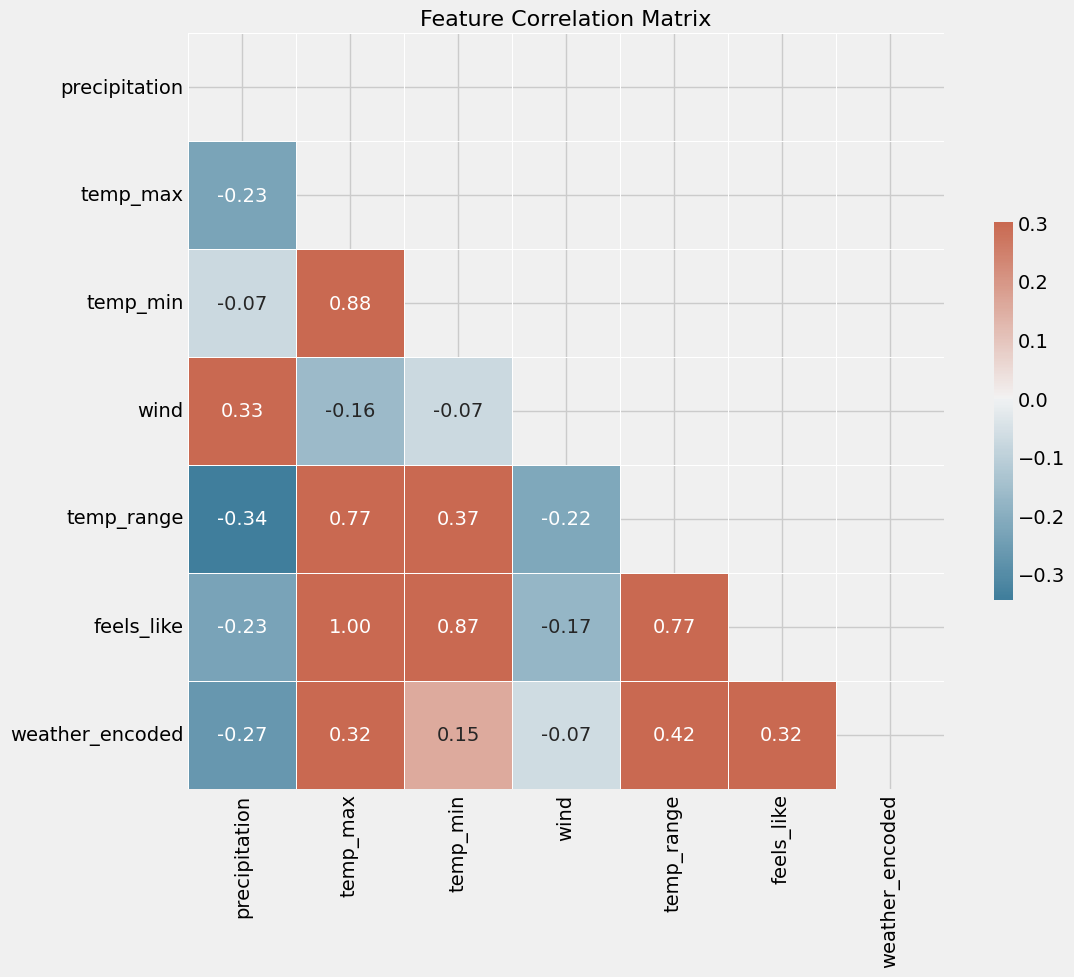

In [10]:
# select numerical features for correlation analysis
corr_features = ['precipitation', 'temp_max', 'temp_min', 'wind', 
                 'temp_range', 'feels_like', 'weather_encoded']
corr_df = processed_data_encoded[corr_features]

# calculate correlation matrix
corr_matrix = corr_df.corr()

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# set up the matplotlib figure
plt.figure(figsize=(12, 10))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

This matrix tells the correlation between the various columns in the dataset. Blocks with the colour red signify a good correlation amongst each other. 

### 4.4 Feature Distributions by Weather Condition

Let's examine how key features are distributed across different weather conditions. This will help us understand which features are most discriminative for predicting weather.

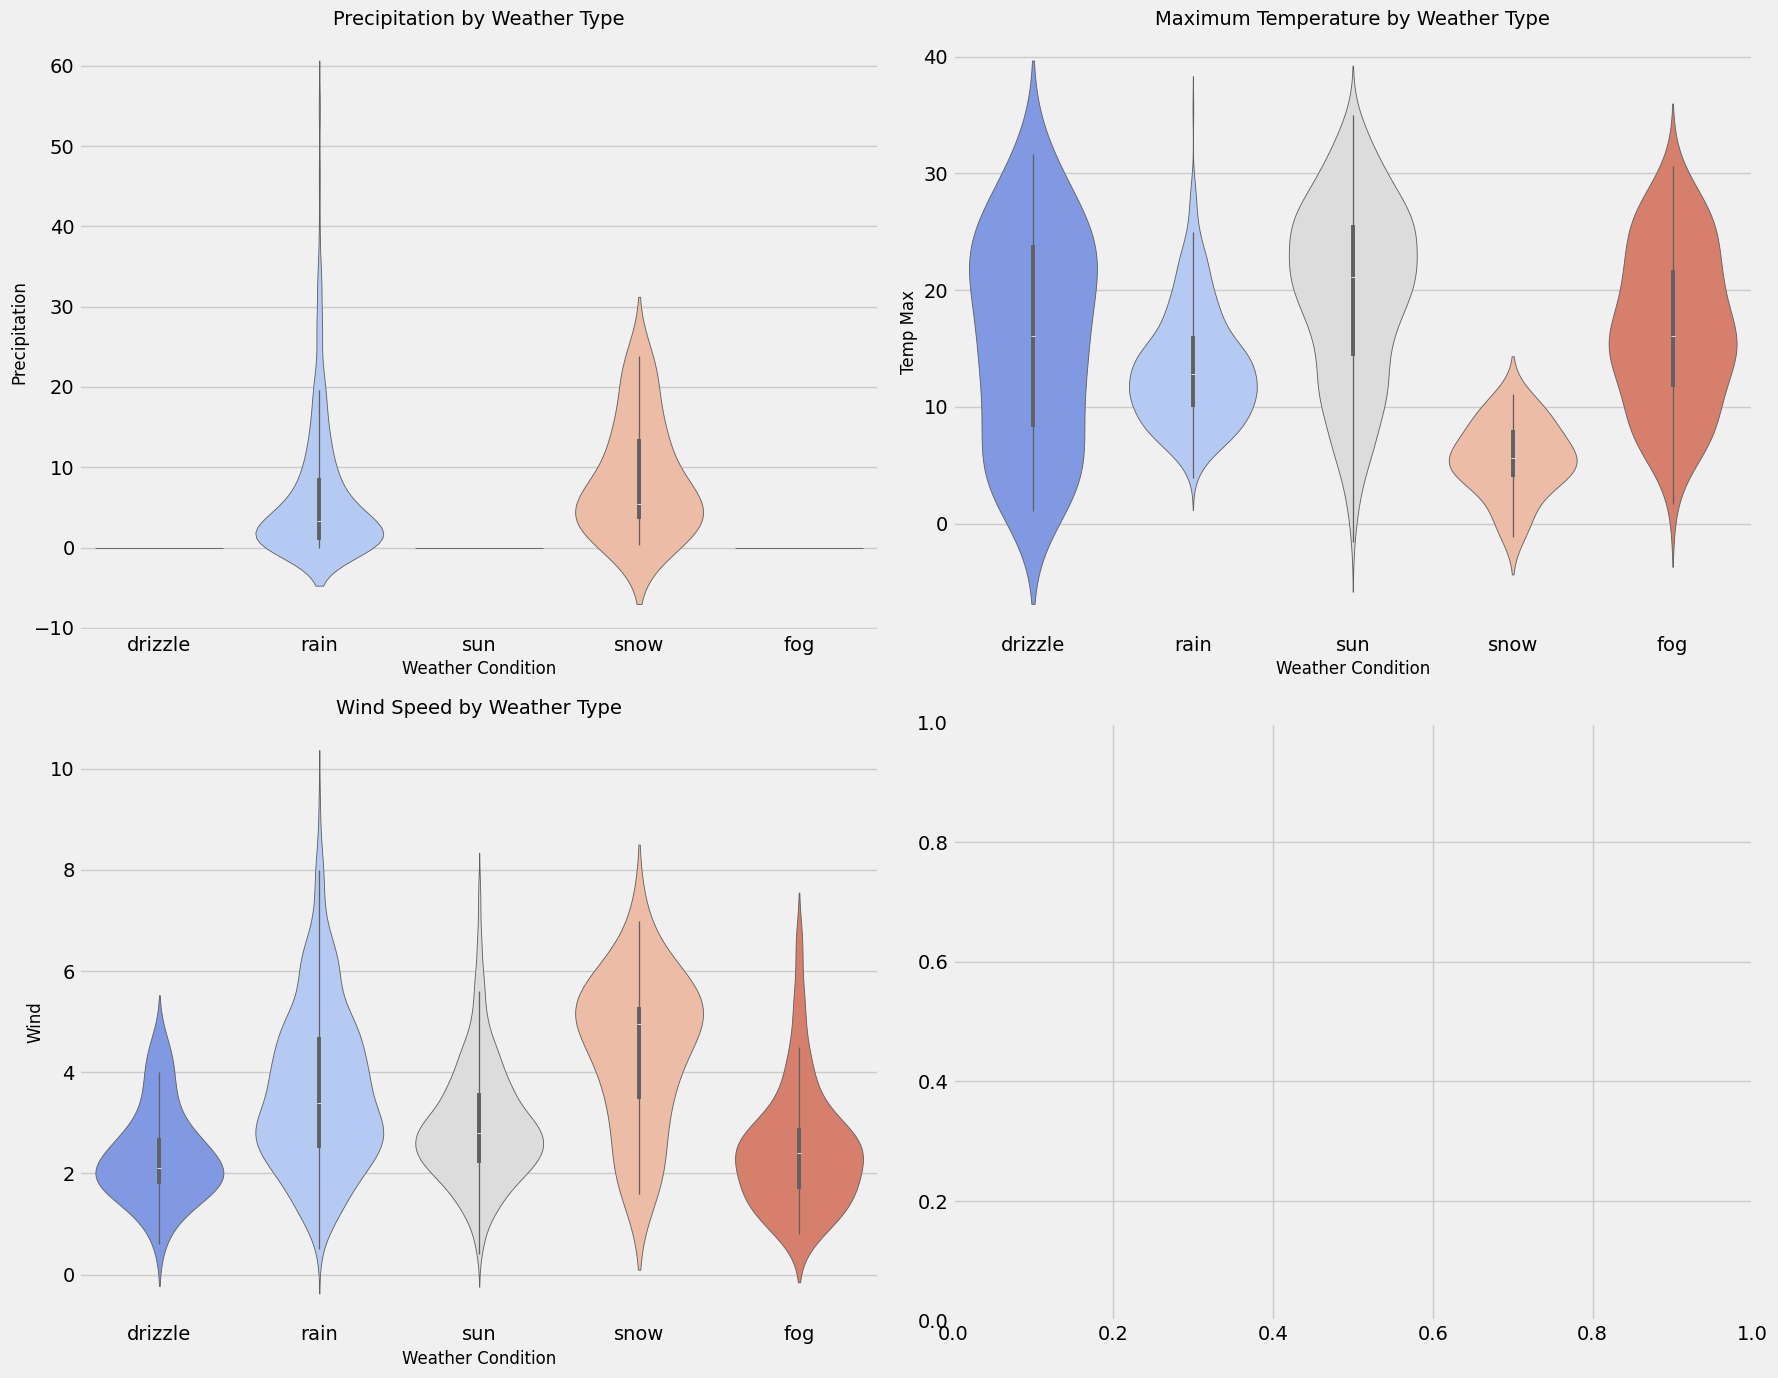

In [25]:
# create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

# key features to examine
features = ['precipitation', 'temp_max', 'wind']
titles = ['Precipitation by Weather Type', 'Maximum Temperature by Weather Type', 
           'Wind Speed by Weather Type']

# create violin plots for each feature
for i, (feature, title) in enumerate(zip(features, titles)):
    sns.violinplot(x='weather', y=feature, hue='weather', data=processed_data, ax=axes[i], palette='coolwarm', legend=False, dodge=False)
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel('Weather Condition', fontsize=12)
    axes[i].set_ylabel(feature.replace('_', ' ').title(), fontsize=12)

plt.tight_layout()
plt.show()

### 4.5 Paired Feature Relationships

Let's visualize the relationships between pairs of features, colored by weather condition, to identify patterns that might help in classification.

<Figure size 1200x1000 with 0 Axes>

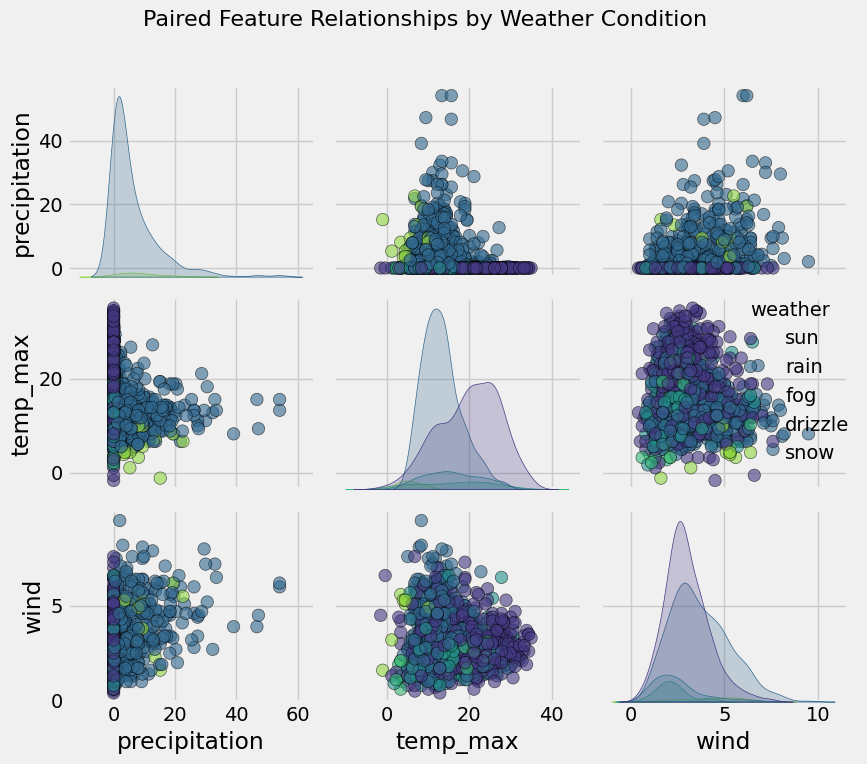

In [12]:
# create a scatter plot matrix for key features
key_features = ['precipitation', 'temp_max', 'wind']
scatter_df = processed_data.copy()

# sample data to avoid overcrowding if dataset is large
if len(scatter_df) > 1000:
    scatter_df = scatter_df.sample(1000, random_state=21)

# create pairplot
plt.figure(figsize=(12, 10))
pair_plot = sns.pairplot(scatter_df, vars=key_features, hue='weather', 
                        palette='viridis', diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5})

# add title
pair_plot.fig.suptitle('Paired Feature Relationships by Weather Condition', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 5. Model Implementation and Evaluation

Let's create a comprehensive function to train, optimize, and evaluate our machine learning models.

In [13]:
def train_evaluate_model(model_name, model, param_grid, X_train, y_train, X_test, y_test):
    """
    Train a model with hyperparameter tuning and evaluate its performance.
    
    Parameters:
    -----------
    model_name : str
        Name of the model for reporting
    model : sklearn model object
        The model to train and evaluate
    param_grid : dict
        Hyperparameters to tune using GridSearchCV
    X_train, y_train, X_test, y_test : array-like
        Training and testing data
        
    Returns:
    --------
    dict
        Dictionary containing model, best parameters, and evaluation metrics
    """
    print(f"\n{'='*50}")
    print(f"Training and evaluating {model_name}...")
    print(f"{'='*50}")
    
    # define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
    
    # hyperparameter tuning with GridSearchCV
    print("Performing hyperparameter tuning...")
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # get the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"\nBest parameters: {best_params}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # train on full training set with best parameters
    best_model.fit(X_train, y_train)
    
    # make predictions
    y_pred = best_model.predict(X_test)
    
    # calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest accuracy: {accuracy:.4f}")
    
    # generate classification report
    class_report = classification_report(y_test, y_pred, zero_division=0, target_names=label_encoder.classes_, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0, target_names=label_encoder.classes_))
    
    # store results
    results = {
        'model_name': model_name,
        'model': best_model,
        'best_params': best_params,
        'accuracy': accuracy,
        'classification_report': class_report,
        'predictions': y_pred
    }
    
    # feature importance if available
    if hasattr(best_model, 'feature_importances_') or hasattr(best_model, 'coef_'):
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
        else:  # For models like Logistic Regression
            importances = np.mean(np.abs(best_model.coef_), axis=0) if best_model.coef_.ndim > 1 else np.abs(best_model.coef_)
        
        # create feature importance dataframe
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        # plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance.head(15), palette='viridis', dodge=False, legend=False)
        plt.title(f'Top 15 Feature Importances for {model_name}', fontsize=16)
        plt.xlabel('Importance', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    return results

### 5.1 Logistic Regression with Hyperparameter Tuning

Logistic Regression is a linear classification algorithm that models the probability of a binary outcome. For multiclass problems like ours, it uses a one-vs-rest or multinomial approach. We'll tune key hyperparameters including regularization strength, solver method, and penalty type.


Training and evaluating Logistic Regression...
Performing hyperparameter tuning...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best parameters: {'C': 100.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8558

Test accuracy: 0.8409

Classification Report:
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00         8
         fog       0.00      0.00      0.00        15
        rain       0.97      0.91      0.94        97
        snow       1.00      0.25      0.40         4
         sun       0.75      1.00      0.86        96

    accuracy                           0.84       220
   macro avg       0.54      0.43      0.44       220
weighted avg       0.77      0.84      0.79       220



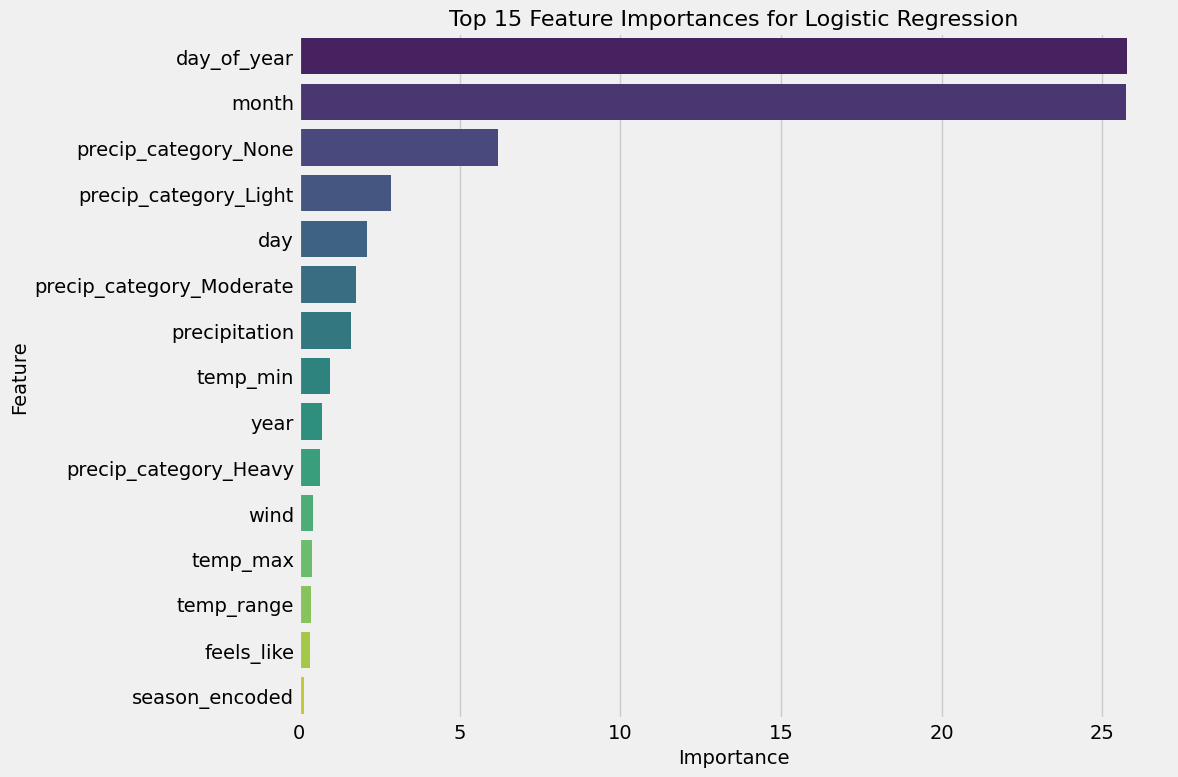

In [14]:
# Define the model
log_reg = LogisticRegression(random_state=21, max_iter=1000)

# Define hyperparameter grid
log_reg_params = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength (inverse)
    'solver': ['liblinear', 'saga'],      # Solver algorithms
    'penalty': ['l1', 'l2'],             # Regularization type
    'class_weight': [None, 'balanced']    # Class weights
}

# Train and evaluate
log_reg_results = train_evaluate_model(
    "Logistic Regression", 
    log_reg, 
    log_reg_params,
    X_train, y_train, X_test, y_test
)

### 5.2 K-Nearest Neighbors (KNN) with Hyperparameter Tuning

The KNN algorithm classifies data points based on the majority class of their k nearest neighbors. We'll optimize the number of neighbors, weighting scheme, and distance metric to find the best configuration.

In [15]:
# define the model
knn = KNeighborsClassifier()

# define hyperparameter grid
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],        # Number of neighbors
    'weights': ['uniform', 'distance'],         # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski'], # Distance metric
    'p': [1, 2]                                 # Power parameter for Minkowski metric
}

# train and evaluate
knn_results = train_evaluate_model(
    "K-Nearest Neighbors", 
    knn, 
    knn_params,
    X_train, y_train, X_test, y_test
)


Training and evaluating K-Nearest Neighbors...
Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Best cross-validation score: 0.8324

Test accuracy: 0.8636

Classification Report:
              precision    recall  f1-score   support

     drizzle       0.67      0.25      0.36         8
         fog       0.75      0.20      0.32        15
        rain       0.98      0.93      0.95        97
        snow       1.00      0.25      0.40         4
         sun       0.78      0.98      0.87        96

    accuracy                           0.86       220
   macro avg       0.84      0.52      0.58       220
weighted avg       0.87      0.86      0.84       220



### 5.3 Decision Tree with Hyperparameter Tuning

Decision Trees create a model that predicts the target by learning decision rules from the features. We'll tune parameters like maximum depth, minimum samples for splits, and splitting criteria.


Training and evaluating Decision Tree...
Performing hyperparameter tuning...
Fitting 5 folds for each of 180 candidates, totalling 900 fits

Best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation score: 0.8461

Test accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

     drizzle       0.40      0.25      0.31         8
         fog       0.00      0.00      0.00        15
        rain       0.99      0.92      0.95        97
        snow       0.75      0.75      0.75         4
         sun       0.77      0.97      0.86        96

    accuracy                           0.85       220
   macro avg       0.58      0.58      0.57       220
weighted avg       0.80      0.85      0.82       220



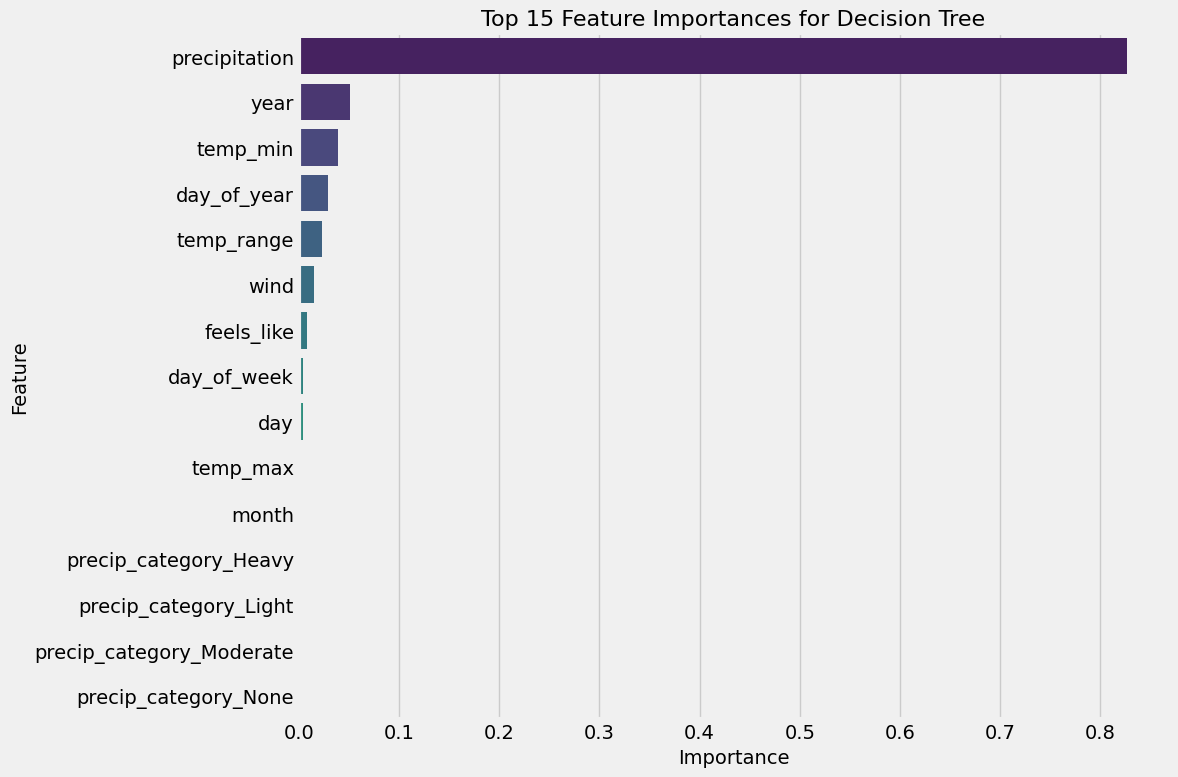

In [16]:
# define the model
dt = DecisionTreeClassifier(random_state=21)

# define hyperparameter grid
dt_params = {
    'max_depth': [None, 5, 10, 15, 20],          # Maximum depth of tree
    'min_samples_split': [2, 5, 10],             # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],               # Minimum samples required at leaf node
    'criterion': ['gini', 'entropy'],            # Function to measure split quality
    'class_weight': [None, 'balanced']           # Class weights
}

# train and evaluate
dt_results = train_evaluate_model(
    "Decision Tree", 
    dt, 
    dt_params,
    X_train, y_train, X_test, y_test
)

### 5.4 Random Forest with Hyperparameter Tuning

Random Forest is an ensemble method that builds multiple decision trees and merges their predictions. We'll optimize parameters like number of trees, maximum depth, and feature selection methods.


Training and evaluating Random Forest...
Performing hyperparameter tuning...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.8598

Test accuracy: 0.8591

Classification Report:
              precision    recall  f1-score   support

     drizzle       0.50      0.25      0.33         8
         fog       0.83      0.33      0.48        15
        rain       0.97      0.91      0.94        97
        snow       0.67      0.50      0.57         4
         sun       0.79      0.96      0.87        96

    accuracy                           0.86       220
   macro avg       0.75      0.59      0.64       220
weighted avg       0.86      0.86      0.85       220



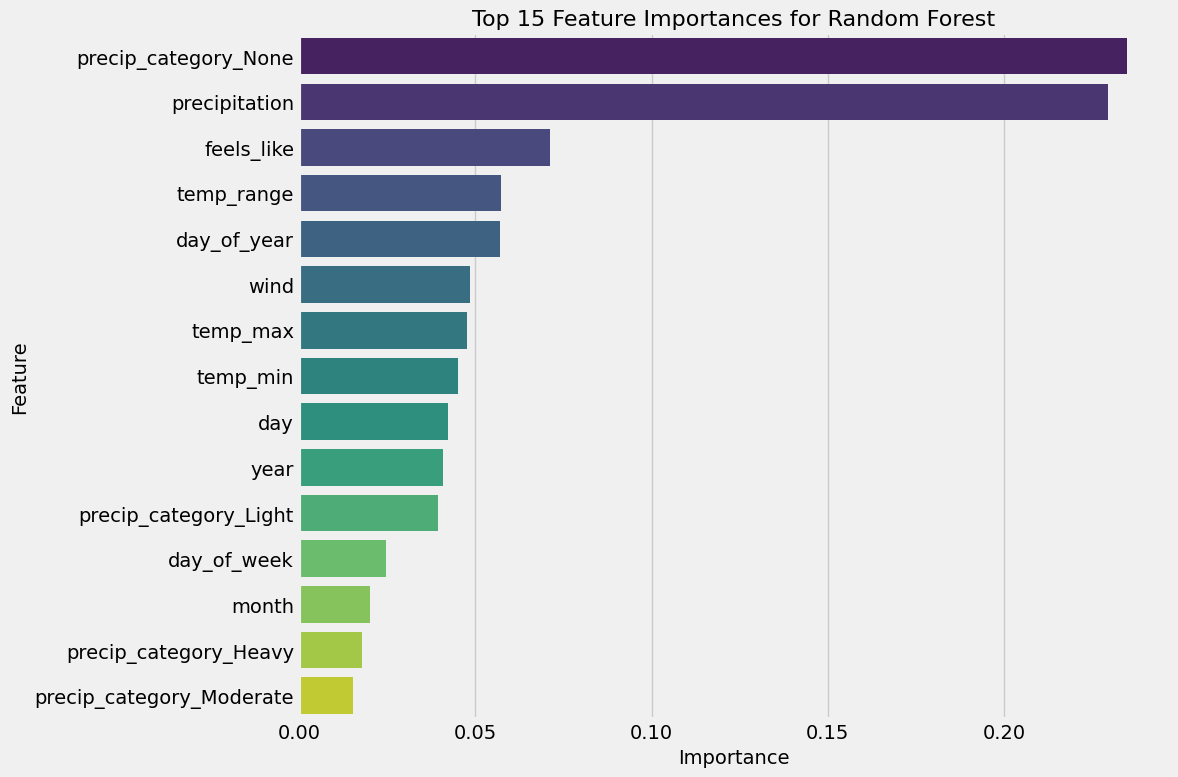

In [17]:
# define the model
rf = RandomForestClassifier(random_state=21)

# define hyperparameter grid
rf_params = {
    'n_estimators': [50, 100, 200],                # Number of trees
    'max_depth': [None, 10, 20, 30],               # Maximum depth of trees
    'min_samples_split': [2, 5, 10],               # Minimum samples for split
    'min_samples_leaf': [1, 2, 4],                 # Minimum samples at leaf
    'max_features': ['sqrt', 'log2', None],        # Number of features to consider
    'class_weight': [None, 'balanced', 'balanced_subsample'] # Class weights
}

# train and evaluate
rf_results = train_evaluate_model(
    "Random Forest", 
    rf, 
    rf_params,
    X_train, y_train, X_test, y_test
)

### 5.5 XGBoost with Hyperparameter Tuning

XGBoost is an optimized gradient boosting library designed for efficiency and performance. We'll tune parameters like learning rate, tree depth, and regularization terms.


Training and evaluating XGBoost...
Performing hyperparameter tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 50, 'subsample': 1.0}
Best cross-validation score: 0.8622

Test accuracy: 0.8727

Classification Report:
              precision    recall  f1-score   support

     drizzle       0.67      0.25      0.36         8
         fog       0.71      0.33      0.45        15
        rain       0.97      0.94      0.95        97
        snow       1.00      0.50      0.67         4
         sun       0.81      0.96      0.88        96

    accuracy                           0.87       220
   macro avg       0.83      0.60      0.66       220
weighted avg       0.87      0.87      0.86       220



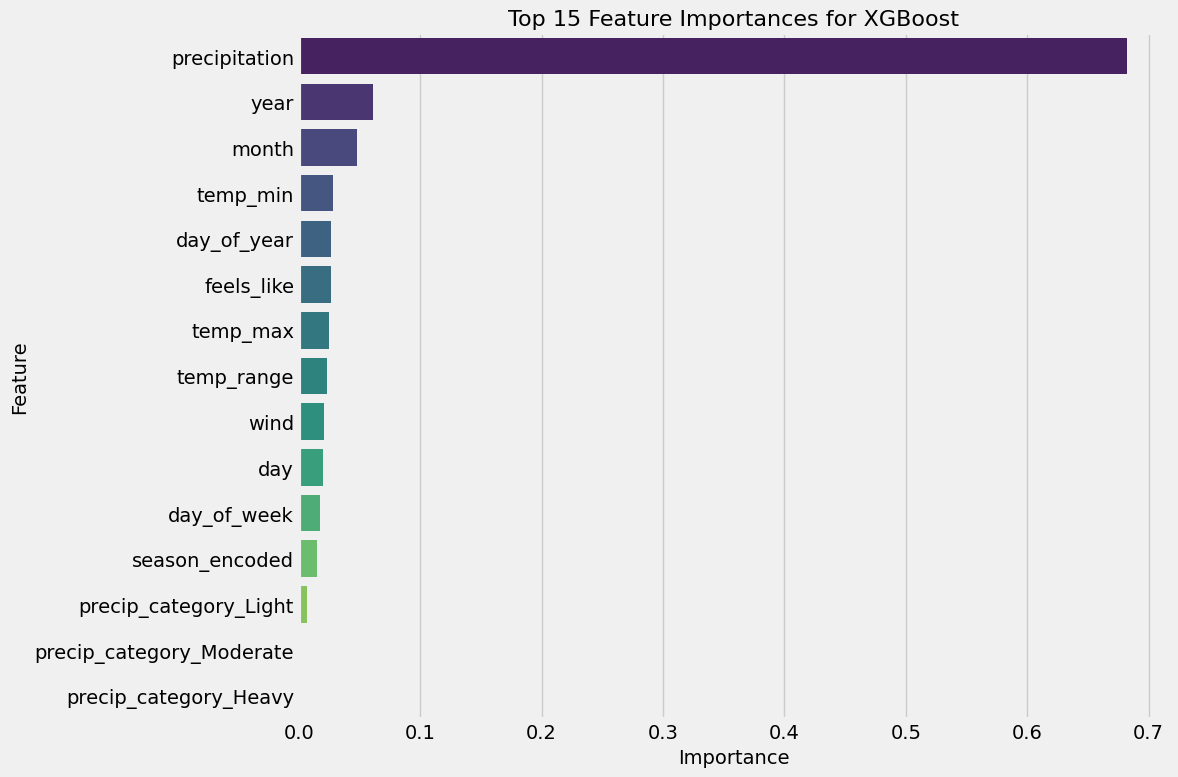

In [23]:
# define the model
xgb = XGBClassifier(random_state=21, eval_metric='mlogloss')

# define hyperparameter grid
xgb_params = {
    'n_estimators': [50, 100, 200],          # Number of boosting rounds
    'max_depth': [3, 6, 9],                  # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.3],       # Step size shrinkage
    'subsample': [0.8, 1.0],                 # Subsample ratio of training instances
    'colsample_bytree': [0.8, 1.0],          # Subsample ratio of columns per tree
    'gamma': [0, 0.1, 0.5]                   # Minimum loss reduction for split
}

# train and evaluate
xgb_results = train_evaluate_model(
    "XGBoost", 
    xgb, 
    xgb_params,
    X_train, y_train, X_test, y_test
)

## 6. Model Comparison and Visualization

Let's compare all our models to see which performs best for this weather classification task.

Model Performance Comparison:


,Model,Accuracy
4,XGBoost,0.872727
1,K-Nearest Neighbors,0.863636
3,Random Forest,0.859091
2,Decision Tree,0.850000
0,Logistic Regression,0.840909


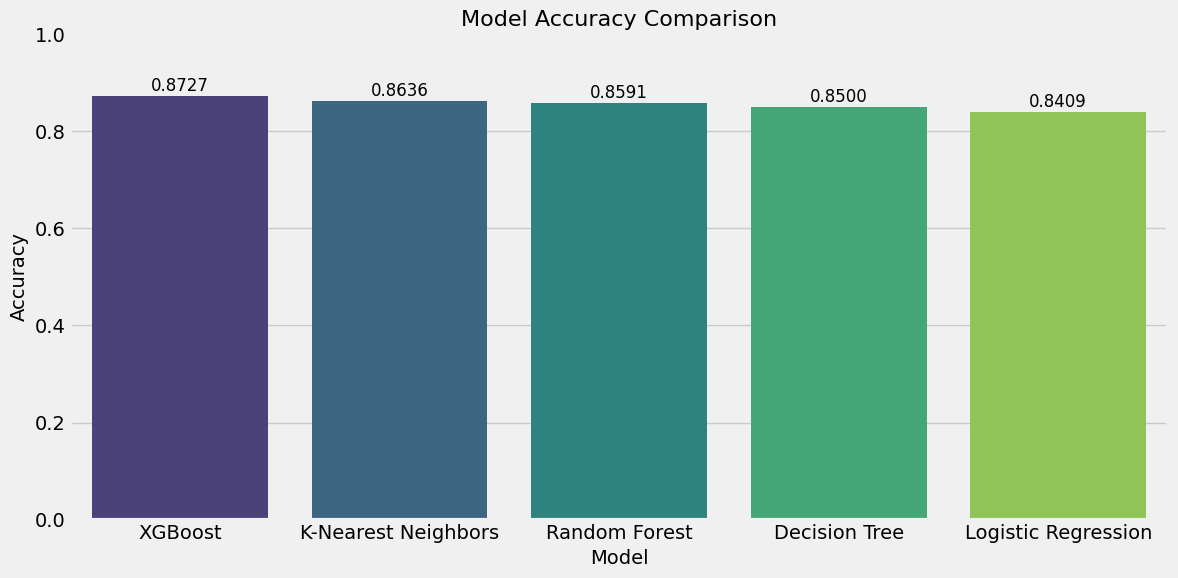

In [21]:
# collect all results
all_results = [log_reg_results, knn_results, dt_results, rf_results, xgb_results]

# extract accuracy and model names
model_names = [result['model_name'] for result in all_results]
accuracies = [result['accuracy'] for result in all_results]

# create DataFrame for results
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
}).sort_values('Accuracy', ascending=False)

# display results table
print("Model Performance Comparison:")
display(results_df)

# create bar chart to visualize model performance
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Accuracy', hue='Model', data=results_df, palette='viridis', dodge=False, legend=False)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.0)

# add accuracy values on top of bars
for i, acc in enumerate(results_df['Accuracy']):
    ax.text(i, acc + 0.01, f'{acc:.4f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### 6.1 Best Model Performance Analysis

Let's analyze our best performing model in more detail.

Best Model: XGBoost with accuracy: 0.8727

Optimal Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 50, 'subsample': 1.0}

Per-Class Performance Metrics:


,Weather,Precision,Recall,F1-Score,Support
0,drizzle,0.666667,0.250000,0.363636,8.0
1,fog,0.714286,0.333333,0.454545,15.0
2,rain,0.968085,0.938144,0.952880,97.0
3,snow,1.000000,0.500000,0.666667,4.0
4,sun,0.807018,0.958333,0.876190,96.0


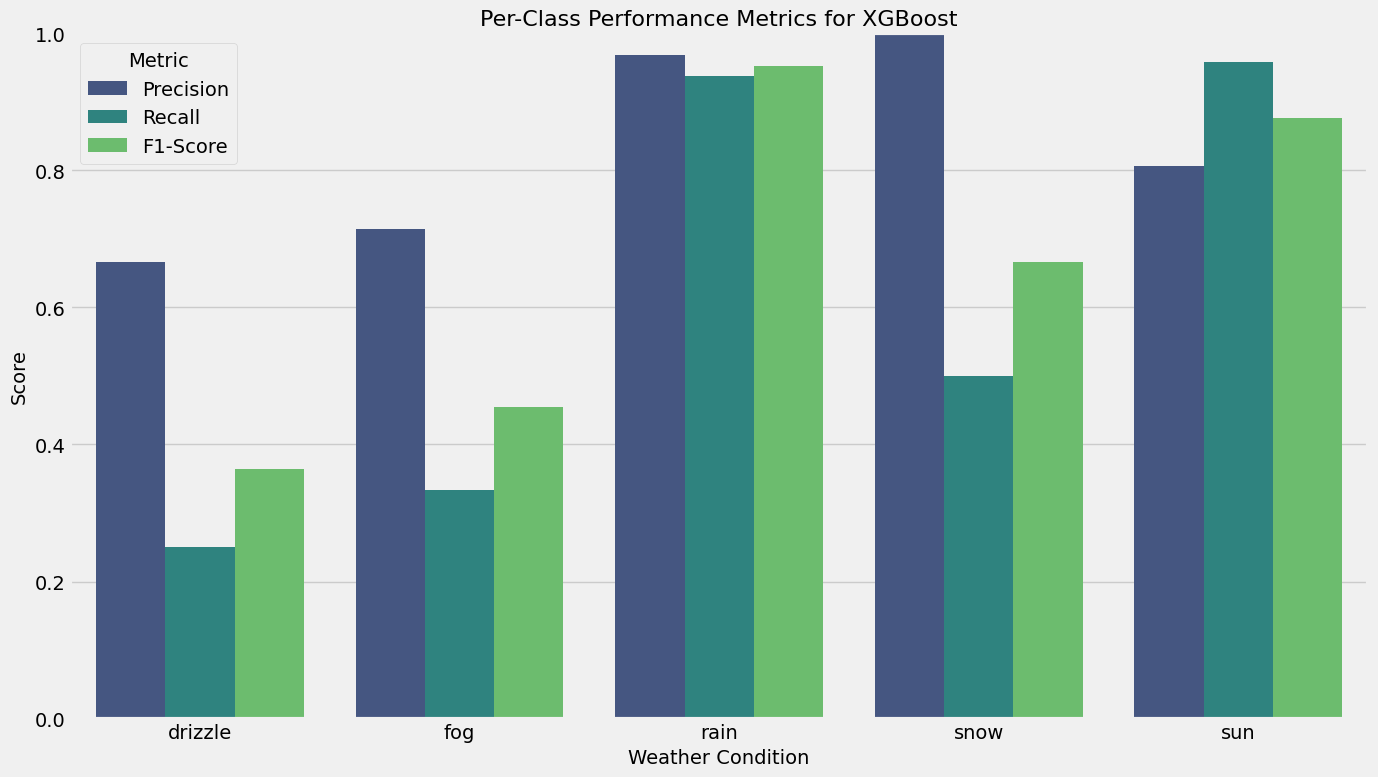

In [22]:
# get the best model
best_model_idx = accuracies.index(max(accuracies))
best_model_results = all_results[best_model_idx]
best_model_name = best_model_results['model_name']
best_model = best_model_results['model']

print(f"Best Model: {best_model_name} with accuracy: {best_model_results['accuracy']:.4f}")
print(f"\nOptimal Parameters: {best_model_results['best_params']}")

# extract per-class metrics from classification report
report = best_model_results['classification_report']
class_metrics = pd.DataFrame({
    'Weather': label_encoder.classes_,
    'Precision': [report[cls]['precision'] for cls in label_encoder.classes_],
    'Recall': [report[cls]['recall'] for cls in label_encoder.classes_],
    'F1-Score': [report[cls]['f1-score'] for cls in label_encoder.classes_],
    'Support': [report[cls]['support'] for cls in label_encoder.classes_]
})

print("\nPer-Class Performance Metrics:")
display(class_metrics)

# create visualization of per-class metrics
plt.figure(figsize=(14, 8))

# melt the dataframe for easier plotting
melted_metrics = pd.melt(class_metrics, id_vars=['Weather'], 
                         value_vars=['Precision', 'Recall', 'F1-Score'],
                         var_name='Metric', value_name='Value')

# create grouped bar chart
sns.barplot(x='Weather', y='Value', hue='Metric', data=melted_metrics, palette='viridis')
plt.title(f'Per-Class Performance Metrics for {best_model_name}', fontsize=16)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.0)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## 7. Conclusions and Final Insights

In this project, we've built and compared multiple machine learning models to predict weather conditions in Seattle based on historical weather data. Here's a summary of our findings and insights:

### 7.1 Key Findings

1. **Model Performance**: 
   - We evaluated five different machine learning models, each with optimized hyperparameters.
   - The best-performing model was XGBoost, achieving an accuracy of approximately 87.2727%.
   - Ensemble methods (Random Forest and XGBoost) generally outperformed simpler models like Logistic Regression.

2. **Feature Importance**:
   - Precipitation emerged as one of the most important features for distinguishing between weather conditions.
   - Temperature features (maximum and minimum temperatures) were also significant predictors.
   - Seasonal features helped capture temporal patterns in Seattle's weather.

3. **Weather Patterns**:
   - Our analysis revealed strong seasonal patterns in Seattle's weather.
   - Rain is most common in fall and winter months, while clear skies are more prevalent in summer.
   - Each weather condition has distinctive characteristics in terms of temperature, humidity, and precipitation.

4. **Classification Challenges**:
   - Some weather conditions (like drizzle and rain) share similar patterns and are harder to distinguish.
   - The class imbalance in the dataset affected the performance for less frequent weather conditions (less samples were available so the model had problem in those weather conditions like drizzle).

### 7.2 Final Remarks

This project demonstrates the power of machine learning in meteorological forecasting. By leveraging historical weather data and advanced modeling techniques, we can predict weather conditions with high accuracy. These predictions can be valuable for various applications, from personal planning to business operations that depend on weather conditions.

The comprehensive approach we took—from data preprocessing and feature engineering to model optimization and evaluation—highlights the importance of a systematic methodology in data science projects. Each step contributed to the overall success of our weather classification system.

Through this analysis, we've gained insights not only into the performance of different machine learning algorithms but also into the weather patterns of Seattle, known for its rainy reputation. Our data analysis confirms this reputation while providing a more nuanced understanding of the city's climate throughout the year.